# 4장 Live Demo
이번 챕터에서는 훈련한 모델을 사용하여 AGV를 부드럽게 이동시키겠습니다.  

## 훈련된 model 불러오기  
"train_model.ipynb" 노트북에서 지시된 대로 이미 best_steering_model_xy.pth를 작업 스테이션에 다운로드했다고 가정합니다. 이제 모델 파일을 인공지능 무인운반차량(AGV)에 업로드하여 이 노트북의 디렉토리로 가져와야 합니다. 업로드가 완료되면 이 노트북의 디렉토리에 best_steering_model_xy.pth라는 이름의 파일이 있어야 합니다.

다음 셀을 호출하기 전에 파일이 완전히 업로드 되었는지 확인해 주십시오.
 
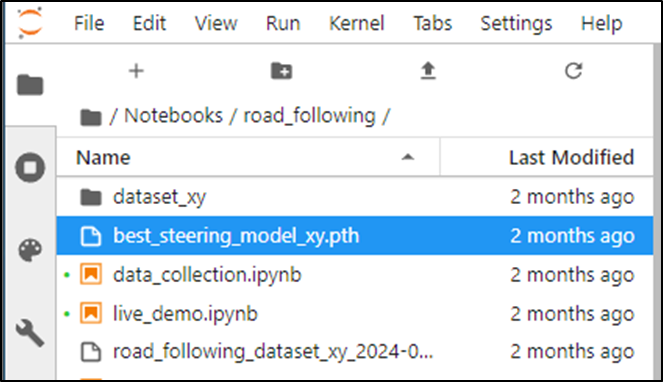  

아래 코드를 실행하여 PyTorch 모델을 초기화합니다.  
이는 훈련 노트북에서 매우 익숙한 내용일 것입니다.  

In [ ]:
import torchvision
import torch

model = torchvision.models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(512, 2)
model.load_state_dict(torch.load('best_steering_model_xy_test_a.pth'))

현재 모델 가중치는 CPU 메모리에 있습니다. 아래 코드를 실행하여 GPU 장치로 전송합니다.

In [ ]:
device = torch.device('cuda')
model = model.to(device)
#.half() : 부동소수점 형식을 16비트로 낮춰서 메모리 사용량을 줄이고 연산 속도를 높인다.
model = model.eval().half()

## 전처리 함수 생성하기  

이제 모델을 로드했지만 약간의 문제가 있습니다.  
훈련된 모델의 형식이 카메라의 형식과 정확히 일치하지 않습니다.  
이를 위해 전처리를 해야 합니다.  
이 과정에는 다음 단계가 포함됩니다.
1. HWC 레이아웃에서 CHW 레이아웃으로 변환합니다.
2. 훈련 중에 사용한 것과 동일한 매개변수를 사용하여 정규화합니다(카메라는 [0, 255] 범위의 값을 제공하고 훈련된 이미지는 [0, 1] 범위로 로드되므로 255.0으로 스케일링해야 합니다).
3. 데이터를 CPU 메모리에서 GPU 메모리로 전송합니다.
4. 배치 차원을 추가합니다.


In [ ]:
import torchvision.transforms as transforms
import torch.nn.functional as F
import cv2
import PIL.Image
import numpy as np

mean = torch.Tensor([0.485, 0.456, 0.406]).cuda().half()
std = torch.Tensor([0.229, 0.224, 0.225]).cuda().half()

def preprocess(image):
    image = PIL.Image.fromarray(image)
    image = transforms.functional.to_tensor(image).to(device).half()
    image.sub_(mean[:, None, None]).div_(std[:, None, None])
    return image[None, ...]

멋지군요!  
이제 카메라 형식을 신경망 입력 형식으로 변환할 수 있는 전처리 함수를 정의했습니다.  
이제 카메라를 시작하고 표시해 봅시다. 지금까지 이것에 대해 꽤 익숙해져 있을 것입니다.

In [ ]:
from IPython.display import display
import ipywidgets
import traitlets
from jetbot import Camera, bgr8_to_jpeg

camera = Camera()
image_widget = ipywidgets.Image()
traitlets.dlink((camera, 'value'), (image_widget, 'value'), transform=bgr8_to_jpeg)
display(image_widget)

우리는 또한 모터를 구동하기 위해 필요한 로봇 인스턴스를 생성할 것입니다.

In [ ]:
from jetbot import Robot

robot = Robot()

이제 인공지능 무인운반차량(AGV)을 제어하기 위한 슬라이더를 정의할 것입니다.
참고: 우리는 가장 잘 알려진 구성에 대한 슬라이더 값을 초기화했지만, 이 값들이 데이터셋에 적합하지 않을 수 있습니다. 따라서 설정 및 환경에 따라 슬라이더 값을 증가시키거나 감소시키십시오.

- 속도 제어 (speed_gain_slider): 인공지능 무인운반차량(AGV)을 시작하려면 speed_gain_slider를 증가시키십시오.
-	조향 게인 제어 (steering_gain_sloder): 인공지능 무인운반차량(AGV)이 흔들린다면, steering_gain_slider를 줄여야 합니다. 그럴 때까지 매끄럽게 합니다.
-	조향 바이어스 제어 (steering_bias_slider): 인공지능 무인운반차량(AGV)이 트랙의 극단적인 오른쪽이나 왼쪽으로 편향된 것을 보면, 이 슬라이더를 조절하여 인공지능 무인운반차량(AGV)이 중앙의 선이나 트랙을 따르기 시작할 때까지 조절해야 합니다. 이것은 모터 편향 및 카메라 오프셋을 고려합니다.

참고: 위에서 언급한 슬라이더를 낮은 속도로 조작하여 부드러운 Road Following 동작을 얻을 수 있습니다.


In [ ]:
speed_gain_slider = ipywidgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.25, description='speed gain')
steering_gain_slider = ipywidgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.2, description='steering gain')
steering_dgain_slider = ipywidgets.FloatSlider(min=0.0, max=0.5, step=0.001, value=0.0, description='steering kd')
steering_bias_slider = ipywidgets.FloatSlider(min=-0.3, max=0.3, step=0.01, value=0.0, description='steering bias')

display(speed_gain_slider, steering_gain_slider, steering_dgain_slider, steering_bias_slider)

다음으로, 인공지능 무인운반차량(AGV)이 생각하는 내용을 볼 수 있는 몇 가지 슬라이더를 표시해 보겠습니다.  
x와 y 슬라이더는 예측된 x, y 값을 표시할 것입니다.  
조향 슬라이더는 우리가 추정한 조향 값을 표시할 것입니다.   
이 값은 실제 목표의 실제 각도가 아니라 거의 비례적인 값입니다. 실제 각도가 0일 때 이 값은 0이 되고, 실제 각도와 함께 증가/감소할 것입니다.

In [ ]:
x_slider = ipywidgets.FloatSlider(min=-1.0, max=1.0, description='x')
y_slider = ipywidgets.FloatSlider(min=0, max=1.0, orientation='vertical', description='y')
steering_slider = ipywidgets.FloatSlider(min=-1.0, max=1.0, description='steering')
speed_slider = ipywidgets.FloatSlider(min=0, max=1.0, orientation='vertical', description='speed')

display(ipywidgets.HBox([y_slider, speed_slider]))
display(x_slider, steering_slider)

다음으로, 카메라 값이 변경될 때마다 호출되는 함수를 생성할 것입니다.   이 함수는 다음 단계를 수행할 것입니다.
1. 카메라 이미지를 전처리합니다.
2. 신경망을 실행합니다.
3. 근사 조향 값을 계산합니다.
4. 비례/미분 제어(PD)를 사용하여 모터를 제어합니다.

In [ ]:
angle = 0.0
angle_last = 0.0

def execute(change):
    global angle, angle_last
    image = change['new']
    xy = model(preprocess(image)).detach().float().cpu().numpy().flatten()
    x = xy[0]
    y = (0.5 - xy[1]) / 2.0
    
    # 인공지능 무인운반차량(AGV)이 가고자 하는 방향의 x,y 값 표시
    x_slider.value = x
    y_slider.value = y
    
    # 인공지능 무인운반차량(AGV)의 속도 표시
    speed_slider.value = speed_gain_slider.value
    
    #조향값 계산
    angle = np.arctan2(x, y)
    
    #PID 제어를 이용한 모터 제어
    pid = angle * steering_gain_slider.value + (angle - angle_last) * steering_dgain_slider.value
    angle_last = angle
    
    steering_slider.value = pid + steering_bias_slider.value
    
    robot.left_motor.value = max(min(speed_slider.value + steering_slider.value, 1.0), -1.0)
    robot.right_motor.value = max(min(speed_slider.value - steering_slider.value, 1.0), -1.0)
    
execute({'new': camera.value})

멋지군요! 이제 처리를 위해 카메라에 우리의 신경망 실행 함수를 연결해야 합니다.  
우리는 그것을 관찰 함수로 달성할 수 있습니다.  
경고: 이 코드는 인공지능 무인운반차량(AGV)을 움직일 것입니다!!   
인공지능 무인운반차량(AGV)이 충분한 공간이 있고, 데이터를 수집한 레고나 트랙 위에 있어야 합니다.   
로드 따라가기는 작동할 것이지만, 신경망은 훈련된 데이터만큼 좋습니다!

In [ ]:
camera.observe(execute, names='value')

## 프로젝트 종료하기

In [ ]:
import time
camera.unobserve(execute, names='value')
time.sleep(0.1) 
robot.stop()
camera.stop()

이것으로 라이브 데모가 끝났습니다!  
아마도 인공지능 무인운반차량(AGV)이 길을 따라 부드럽게 움직이는 것을 보는 것이 재미있었을 것입니다!  

만약 인공지능 무인운반차량(AGV)이 도로를 잘 따라가지 못한다면, 어디서 실패하는지 찾아보세요.  
다음 챕터에서 우리는 수동으로 인공지능 무인운반차량(AGV)을 제어하여 학습한 model이 길에서 어떤 방향으로 나아가려 하는 지 피드백을 해볼 겁니다.  